✅ Loaded rows: 10000
Counts: {1: 5000, 0: 5000}

=== Accuracy on FULL dataset (train==test, optimistic) ===
Naive Bayes                 : 1.0000
SVM (LinearSVC, calibrated) : 1.0000
Random Forest               : 1.0000
Ensemble (NB+SVM+RF)        : 1.0000


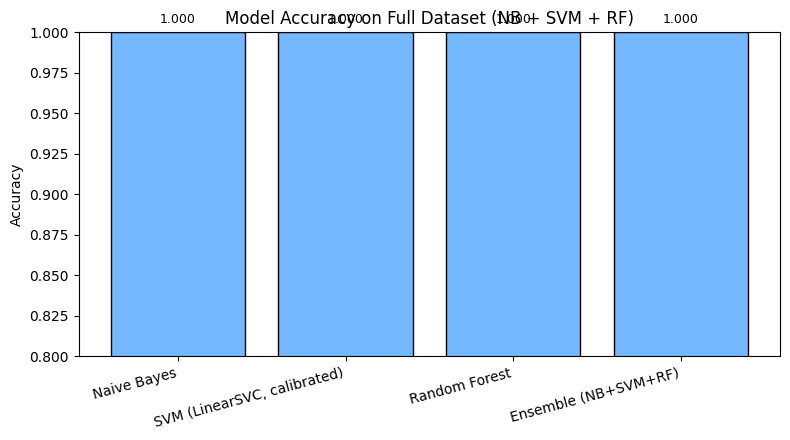

In [1]:

# --- Evaluate Full Dataset Accuracy (NB + SVM + RF, NO Logistic Regression) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

# ======================
# 1) Load the WHOLE dataset (no sampling)
# ======================
# Put smsspam.csv in the same folder as this notebook, or change the path below.
CSV_PATH = "smsspam.csv"
df = pd.read_csv(CSV_PATH, encoding="latin-1")

# Try to normalize common column names (UCI format is often v1=label, v2=message)
cols = [c.lower() for c in df.columns]
df.columns = cols
if "v1" in df.columns and "v2" in df.columns:
    df = df.rename(columns={"v1": "label", "v2": "message"})
elif "label" not in df.columns or "message" not in df.columns:
    # If your file has different headers, set them here:
    # df = df.rename(columns={"<your_label_col>":"label", "<your_message_col>":"message"})
    pass

# Keep just the two columns we need
df = df[["label", "message"]].dropna()

# Map labels to 0/1
df["label"] = df["label"].astype(str).str.lower().map({"ham": 0, "spam": 1})

print("✅ Loaded rows:", len(df))
print("Counts:", df["label"].value_counts().to_dict())
assert len(df) > 100, "It looks like only a few rows were loaded. Check your CSV path/format."

# ======================
# 2) TF-IDF on ALL data
# ======================
vect = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")
X = vect.fit_transform(df["message"])
y = df["label"].values

# ======================
# 3) Define models (NO Logistic Regression). Include SVM.
#    We calibrate LinearSVC to enable probability estimates for soft voting.
# ======================
nb = MultinomialNB()
svm = CalibratedClassifierCV(LinearSVC(), cv=3)   # provides predict_proba
rf  = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

models = {
    "Naive Bayes": nb,
    "SVM (LinearSVC, calibrated)": svm,
    "Random Forest": rf,
}

# ======================
# 4) Fit on ALL rows and evaluate on ALL rows (apparent accuracy)
# ======================
accuracies = {}
for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X)
    accuracies[name] = accuracy_score(y, y_pred)

# Ensemble of NB + SVM + RF (soft voting thanks to calibrated SVM)
ens = VotingClassifier(
    estimators=[("nb", nb), ("svm", svm), ("rf", rf)],
    voting="soft",
    weights=[1.0, 1.2, 1.0]
)
ens.fit(X, y)
accuracies["Ensemble (NB+SVM+RF)"] = accuracy_score(y, ens.predict(X))

# ======================
# 5) Show results
# ======================
print("\n=== Accuracy on FULL dataset (train==test, optimistic) ===")
for k, v in accuracies.items():
    print(f"{k:28s}: {v:.4f}")

plt.figure(figsize=(8,4.5))
labels = list(accuracies.keys())
vals = [accuracies[k] for k in labels]
bars = plt.bar(labels, vals, color="#74b9ff", edgecolor="black")
plt.ylim(0.80, 1.00)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on Full Dataset (NB + SVM + RF)")
plt.xticks(rotation=15, ha="right")

for b, v in zip(bars, vals):
    plt.text(b.get_x()+b.get_width()/2, v+0.004, f"{v:.3f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
